# Calculating features of ellipses from numbers

>1. Load data
>2. Determine center-to-center distance that best separates 0 from other numbers
>3. Determine ratio of areas of 0s vs. other numbers
>4. Calculate aspect ratio of 1s that best separates from other numbers
>5. Calculate ratio of areas of 6s vs. other numbers
>6. Calculate center-to-center distance of ellipses in 6s vs. other numbers
>7. Calculate ratio of areas of top/bottom ellipses to middle ellipses in 8s vs. other numbers

**Results:**
>1. Done
>2. 0: center_to_center_dist < 1.4
>3. 0: ratio_of_areas < 3
>4. 1: aspect_ratio > 3.6
>5. 6: ratio_of_area_top_to_bottom > 2
>6. 6: center_to_center_distance 2 < x < 7
>7. Checking that biggest ellipse is in the center works fairly well

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
import seaborn as sns
sns.set_context(context = 'notebook', font_scale=1.5)
import os
import sys
import cv2

base_path = '/home/lundi/Python/MNIST/'
sys.path.append(base_path + '/libraries/')

import MNIST_data_processor as mdp

MNIST_data_processor = mdp.MNIST_data_processor()

from matplotlib.patches import Ellipse

## 1. Load data

In [2]:
X, y = MNIST_data_processor.load_subset_data()

## 2. Determine center-to-center distance that best separates 0 from other numbers

In [3]:
def convert_to_image(data):
    img = np.zeros((28, 28,3))
    img[:,:,0] = data.reshape(28,28)
    img[:,:,1] = data.reshape(28,28)
    img[:,:,2] = data.reshape(28,28)
    
    img = img.astype('uint8')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img

In [4]:
def get_distance_between_ellipses(ellipse_1, ellipse_2):
    return np.sqrt(((ellipse_1[0][0] - ellipse_2[0][0]) ** 2) + ((ellipse_1[0][1] - ellipse_2[0][1]) ** 2))

In [5]:
def get_valid_contours(digit_data):
    image = convert_to_image(digit_data)
    
    ret,thresh = cv2.threshold(image,127,255,0)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)

    valid_contours = []
    #Get the valid contours
    for cnt in contours:
        if len(cnt) >= 5:
            valid_contours.append(cnt)
    return valid_contours

In [6]:
def get_center_to_center_dist(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 2:
        ellipse = []
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
        ellipse_2 = cv2.fitEllipse(valid_contours[1])
                
        distance = get_distance_between_ellipses(ellipse_1, ellipse_2)
        
        return distance
    else:
        return -1

In [7]:
result_data = pd.concat([X.apply(get_center_to_center_dist, axis=1), y], axis=1).replace(-1, np.nan).dropna()
result_data = result_data.rename(columns = {0: 'center_to_center_dist'})

We know that the center to center distance can't be > 28, let's remove these:

In [8]:
result_data = result_data.loc[result_data['center_to_center_dist'] < 28]

Comparing the center-to-center differences of all the classes

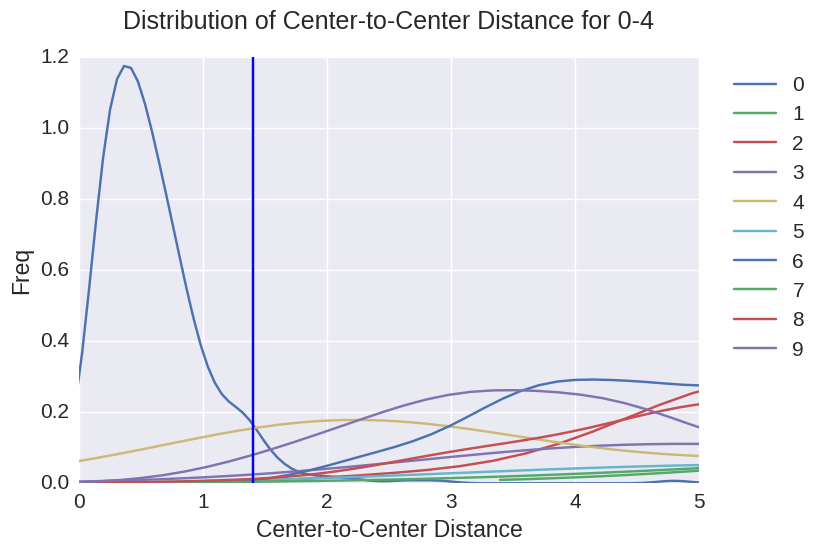

In [9]:
for label_index in xrange(0,10): 
    label_data = result_data.loc[result_data['label'] == label_index, 'center_to_center_dist']
    
    sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Center-to-Center Distance')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Center-to-Center Distance for 0-4', y=1.05)
ax.set_xlim([0,5])
ax.axvline(1.4)

I will use 1.4 as maximum center-to-center distance. This includes most 0s and minimal amounts of other numbers

In [10]:
result_data_v1 = result_data.loc[result_data['center_to_center_dist'] < 1.4]
X_v1 = X.loc[result_data_v1.index]

In [11]:
result_data_v1['label'].value_counts() / result_data_v1.shape[0]

0    0.964029
9    0.026379
4    0.004796
8    0.002398
6    0.002398
Name: label, dtype: float64

This is a good sign, 0s make up 96.4% of the data, with 9s at 2.6%. 

## 3. Determine ratio of areas of 0s vs. other numbers

In [12]:
def get_ratio_of_areas_big_to_small(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 2:
        ellipse = []
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
        ellipse_2 = cv2.fitEllipse(valid_contours[1])
                
        area_ellipse_1, area_ellipse_2 = (ellipse_1[1][0] * ellipse_1[1][1] * np.pi), (ellipse_2[1][0] * ellipse_2[1][1] * np.pi)
        
        ratio_of_areas = 1.0 * area_ellipse_1 / area_ellipse_2
        if ratio_of_areas < 1:
            ratio_of_areas = 1.0 / ratio_of_areas
        return ratio_of_areas
    else:
        return -1

In [13]:
ratio_data_0 = pd.concat([X_v1.apply(get_ratio_of_areas_big_to_small, axis=1), y], axis=1).replace(-1, np.nan).dropna()
ratio_data_0 = ratio_data_0.rename(columns = {0: 'ratio_of_areas'})

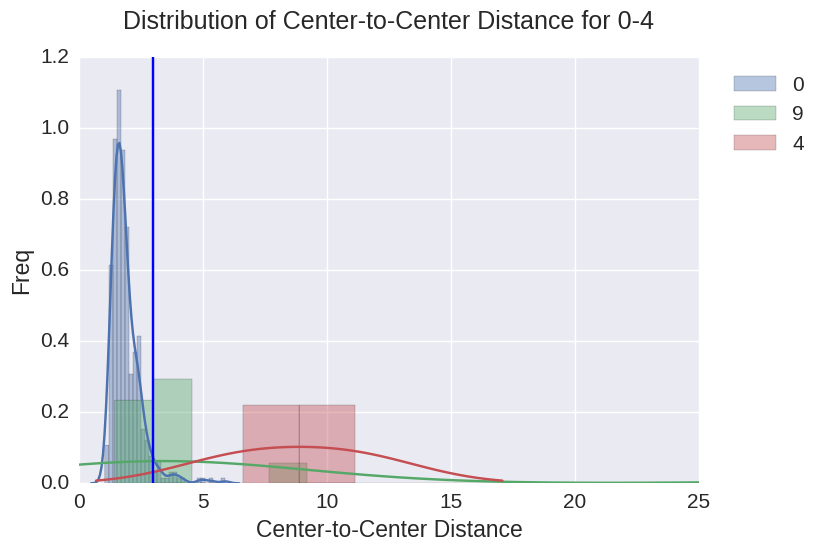

In [14]:
for label_index in ratio_data_0['label'].unique(): 
    label_data = ratio_data_0.loc[ratio_data_0['label'] == label_index, 'ratio_of_areas']
    if label_data.shape[0] > 1:
        sns.distplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Center-to-Center Distance')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Center-to-Center Distance for 0-4', y=1.05)
ax.set_xlim([0,25])
ax.axvline(3)

I can use a maximum ratio of 3

In [15]:
ratio_data_0_filtered = ratio_data_0.loc[ratio_data_0['ratio_of_areas'] < 3]

ratio_data_0_filtered['label'].value_counts() / ratio_data_0_filtered.shape[0]

0    0.989691
9    0.010309
Name: label, dtype: float64

So this label corresponds to 98.9% 0s and 1% 9s.

## 4. Calculate aspect ratio of 1s that best separates from other numbers

Calculating the aspect ratio of all numbers

In [16]:
def get_aspect_ratio(ellipse):
    aspect_ratio = ellipse[1][1] / ellipse[1][0]
    return aspect_ratio

In [17]:
def get_aspect_ratio_of_single_ellipses(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 1:
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
                        
        return get_aspect_ratio(ellipse_1)
    else:
        return -1

In [18]:
result_data = pd.concat([X.apply(get_aspect_ratio_of_single_ellipses, axis=1), y], axis=1).replace(-1, np.nan).dropna()
result_data = result_data.rename(columns = {0: 'aspect_ratio'})

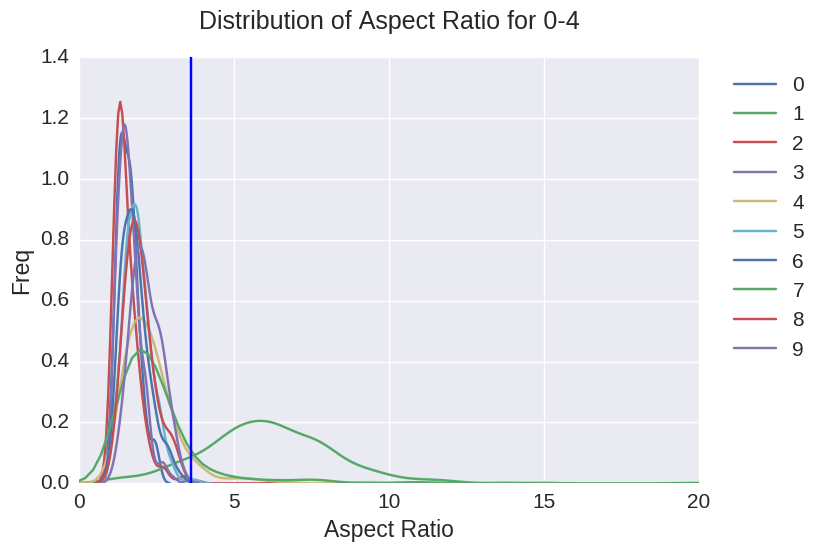

In [19]:
for label_index in xrange(0,10): 
    label_data = result_data.loc[result_data['label'] == label_index, 'aspect_ratio']
    
    sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Aspect Ratio')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Aspect Ratio for 0-4', y=1.05)
ax.set_xlim([0,20])
ax.axvline(3.6)

Using a cutoff of 3.6 looks good here

In [20]:
result_data_v1 = result_data.loc[result_data['aspect_ratio'] > 3.6]
result_data_v1['label'].value_counts() / result_data_v1.shape[0]

1    0.841924
7    0.091065
4    0.060137
5    0.003436
2    0.003436
Name: label, dtype: float64

This results in 84% 1's, and 9.1% of 7s, and 6% of 4s

## 5. Calculate ratio of areas of 6s vs. other numbers

## 6. Calculate center-to-center distance of ellipses in 6s vs. other numbers

In [21]:
def get_ratio_of_areas_top_to_bottom(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 2:
        ellipse = []
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
        ellipse_2 = cv2.fitEllipse(valid_contours[1])
        
        area_ellipse_1, area_ellipse_2 = (ellipse_1[1][0] * ellipse_1[1][1] * np.pi), (ellipse_2[1][0] * ellipse_2[1][1] * np.pi)
        
        is_1_on_top = ellipse_1[0][1] < ellipse_2[0][1]
        if is_1_on_top:
            ratio_of_areas = area_ellipse_1 / area_ellipse_2
        else:
            ratio_of_areas = area_ellipse_2 / area_ellipse_1
        return ratio_of_areas
    else:
        return -1

In [22]:
ratio_data_6 = pd.concat([X.apply(get_ratio_of_areas_top_to_bottom, axis=1), y], axis=1).replace(-1, np.nan).dropna()
ratio_data_6 = ratio_data_6.rename(columns = {0: 'ratio_of_areas'})

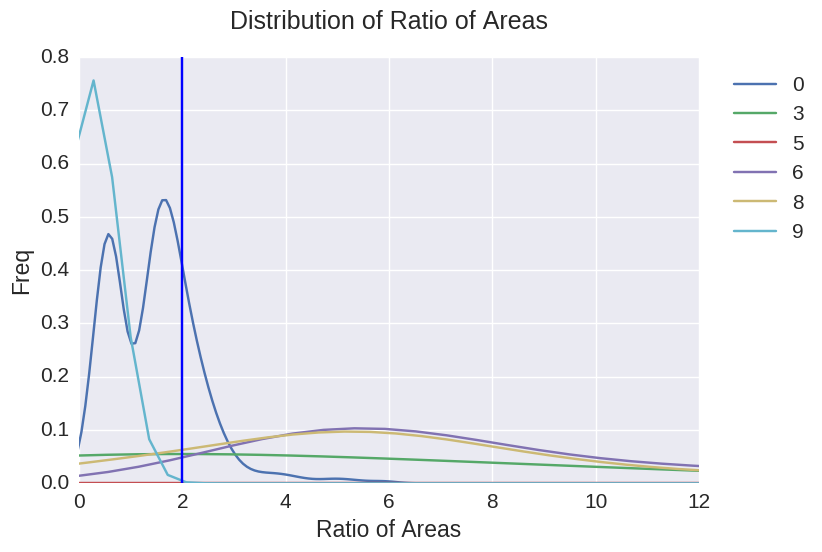

In [23]:
for label_index in [0,3,5,6,8,9]: 
    label_data = ratio_data_6.loc[ratio_data_6['label'] == label_index, 'ratio_of_areas']

    sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Ratio of Areas')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Ratio of Areas', y=1.05)
ax.set_xlim([0,12])
ax.axvline(2)

A threshold at ratio = 2 cuts out nearly all 9s

In [24]:
ratio_data_6_v1 = ratio_data_6.loc[ratio_data_6['ratio_of_areas'] > 2]
X_v1 = X.loc[ratio_data_6_v1.index]

In [25]:
center_to_center_data = pd.concat([X_v1.apply(get_center_to_center_dist, axis=1), y], axis=1).replace(-1, np.nan).dropna()
center_to_center_data = center_to_center_data.rename(columns = {0: 'center_to_center_dist'})

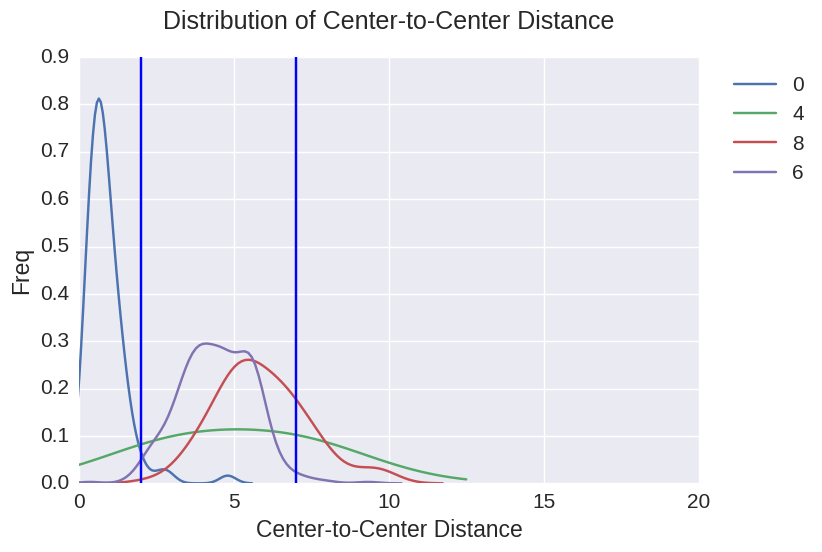

In [26]:
for label_index in ratio_data_0['label'].unique(): 
    label_data = center_to_center_data.loc[center_to_center_data['label'] == label_index, 'center_to_center_dist']
    if label_data.shape[0] > 1:
        sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Center-to-Center Distance')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Center-to-Center Distance', y=1.05)
ax.set_xlim([0,20])
ax.axvline(2)
ax.axvline(7)

Min: 2
Max: 7

## 7. Calculate ratio of areas of top/bottom ellipses to middle ellipses in 8s vs. other numbers

In [98]:
def get_big_ellipse_in_center(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 3:
        ellipse = [0,0,0]
        ellipse[0] = cv2.fitEllipse(valid_contours[0])
        ellipse[1] = cv2.fitEllipse(valid_contours[1])
        ellipse[2] = cv2.fitEllipse(valid_contours[2])

        ellipse_area = [0,0,0]
        ellipse_area[0] = (ellipse[0][1][0] * ellipse[0][1][1] * np.pi) 
        ellipse_area[1] = (ellipse[1][1][0] * ellipse[1][1][1] * np.pi)

        ellipse_area[2] = (ellipse[2][1][0] * ellipse[2][1][1] * np.pi)

        
        max_area_ellipse_index = pd.Series(ellipse_area).idxmax()
        largest_ellipse = ellipse[max_area_ellipse_index]
        other_ellipse_indexes = [0,1,2]
        other_ellipse_indexes.remove(max_area_ellipse_index)
        
        other_ellipse_1 = ellipse[other_ellipse_indexes[0]]
        other_ellipse_2 = ellipse[other_ellipse_indexes[1]]

        #If the 1st other ellipse is above the 2nd
        if other_ellipse_1[0][1] < other_ellipse_2[0][1]:
            top_ellipse = other_ellipse_1
            bottom_ellipse = other_ellipse_2
        else:
            top_ellipse = other_ellipse_2
            bottom_ellipse = other_ellipse_1
            
        top_to_mid_dist = get_distance_between_ellipses(top_ellipse, largest_ellipse)
        bottom_to_mid_dist = get_distance_between_ellipses(bottom_ellipse, largest_ellipse)
        
        #The center ellipse should be larger than the 1st, and less than the second
        is_in_middle = (largest_ellipse[0][1] > top_ellipse[0][1]) \
                            & (largest_ellipse[0][1] < bottom_ellipse[0][1])
        return is_in_middle
        
    else:
        return False

In [96]:
result_data_8 = pd.concat([X.apply(get_big_ellipse_in_center, axis=1), y], axis=1).replace(-1, np.nan).dropna()
result_data_8 = result_data_8.rename(columns = {0: 'dummy_var',1: 'top_to_mid_dist', 2: 'bottom_to_mid_dist'})

In [97]:
result_data_8.reset_index().groupby(['dummy_var','label'])['index'].count()

dummy_var  label
False      0        484
           1        558
           2        543
           3        480
           4        477
           5        467
           6        512
           7        506
           8        180
           9        477
True       0         10
           2          2
           5          2
           6          4
           8        298
           9          1
Name: index, dtype: int64

In [31]:
(result_data_8.reset_index().groupby(['is_in_middle','label'])['index'].count() / result_data_8.shape[0]).loc[True]

label
0    0.029762
2    0.005952
5    0.005952
6    0.011905
8    0.886905
9    0.002976
Name: index, dtype: float64

# Dummy variable for 9

In [31]:
def get_ratio_of_areas_top_to_bottom(digit_data):
    
    valid_contours = get_valid_contours(digit_data)
    
    if len(valid_contours) == 2:
        ellipse = []
        ellipse_1 = cv2.fitEllipse(valid_contours[0])
        ellipse_2 = cv2.fitEllipse(valid_contours[1])
        
        area_ellipse_1, area_ellipse_2 = (ellipse_1[1][0] * ellipse_1[1][1] * np.pi), (ellipse_2[1][0] * ellipse_2[1][1] * np.pi)
        
        is_1_on_top = ellipse_1[0][1] < ellipse_2[0][1]
        if is_1_on_top:
            ratio_of_areas = area_ellipse_1 / area_ellipse_2
        else:
            ratio_of_areas = area_ellipse_2 / area_ellipse_1
        return ratio_of_areas
    else:
        return -1

(0, 12)

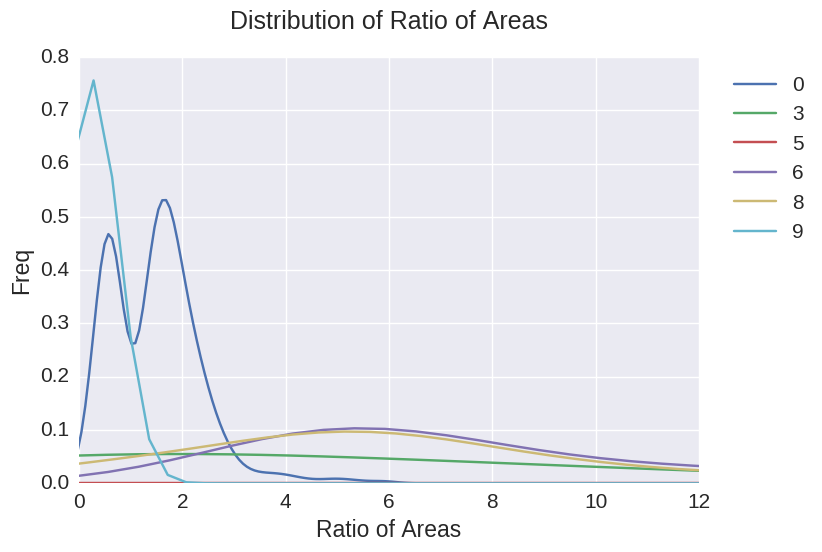

In [32]:
ratio_data_9 = pd.concat([X.apply(get_ratio_of_areas_top_to_bottom, axis=1), y], axis=1).replace(-1, np.nan).dropna()
ratio_data_9 = ratio_data_9.rename(columns = {0: 'ratio_of_areas'})

for label_index in [0,3,5,6,8,9]: 
    label_data = ratio_data_6.loc[ratio_data_6['label'] == label_index, 'ratio_of_areas']

    sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Ratio of Areas')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Ratio of Areas', y=1.05)
ax.set_xlim([0,12])

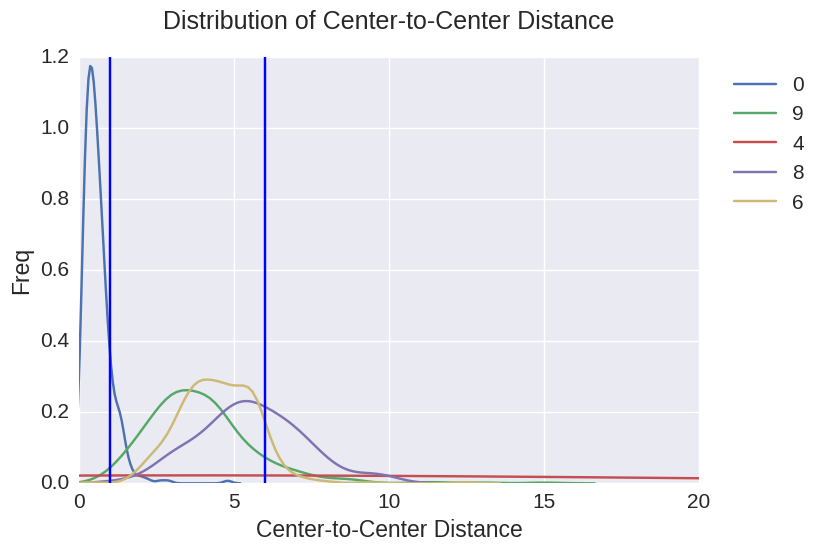

In [36]:
center_to_center_data = pd.concat([X.apply(get_center_to_center_dist, axis=1), y], axis=1).replace(-1, np.nan).dropna()
center_to_center_data = center_to_center_data.rename(columns = {0: 'center_to_center_dist'})

for label_index in ratio_data_0['label'].unique(): 
    label_data = center_to_center_data.loc[center_to_center_data['label'] == label_index, 'center_to_center_dist']
    if label_data.shape[0] > 1:
        sns.kdeplot(label_data, label = str(label_index))
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.2,1))
ax.set_xlabel('Center-to-Center Distance')
ax.set_ylabel('Freq')
ax.set_title('Distribution of Center-to-Center Distance', y=1.05)
ax.set_xlim([0,20])
ax.axvline(1)
ax.axvline(6)